# Metamaterials Test
The purpose of this Jupyter Enviroment is to familarize myself with the data/model being used in this project, as well as to test out some of my own code relating to the project

In [1]:
import scipy.stats

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def plot_shape(shape_matrix):
    """Plot the generated shape."""
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(3,3))
    ax.set_facecolor('#301934')
    ax.imshow(shape_matrix, origin='upper')
    plt.axis('off')
    plt.show()


filename = "train_test_split.h5"

with h5py.File(filename, "r") as h:
    a_group_key = list(h.keys())[0]
    data = list(h[a_group_key])

    def show_index(i):
        print(f"params_train[{i}]: {h['params_train'][i]}")
        print(f"neff_train[{i}]: {h['neff_train'][i]}")
        print(f'pattern_train[{i}]:')
        plot_shape(h['pattern_train'][i])
        print(f"weight_train[{i}]: {h['weight_train'][i]}")
        print(f"Total Modal Percentage: {sum(h['weight_train'][i])}")
        plt.figure(figsize=(2.5,2.5))
        plt.xlabel('Mode Number')
        plt.ylabel('Percentage')
        plt.errorbar([1,2,3,4], h['weight_train'][i], fmt='o')
        plt.plot([1,2,3,4], h['weight_train'][i])

    all_percentages = []
    p_labeled = {}
    for i in range(len(h['params_train'])):
        modal_percentage = sum(h['weight_train'][i])
        all_percentages.append(modal_percentage)
        info = {'pattern': h['pattern_train'][i], 'params': h['params_train'][i], 'neff':  h['neff_train'][i], 'weights': h['weight_train'][i]}
        key = int(modal_percentage)
        if key in p_labeled.keys():
            p_labeled[key].append(info)
        else:
            p_labeled[key] = [info]
        # if modal_percentage < 80:
        #     less_than_80.append(i)
        # if modal_percentage < 50:
        #     less_than_50.append(i)
    data = list(h[a_group_key])
    # preferred methods to get dataset values:
    ds_obj = h[a_group_key]      # returns as a h5py dataset object
    ds_arr = h[a_group_key][()]  # returns as a numpy array

KeyboardInterrupt: 

Eigenmodes: tensor([4.9921, 1.5929, 0.5911, 0.0000])
Weights: tensor([7.7262e+01, 1.4055e+01, 8.6509e+00, 2.6938e-05])
Params: tensor([1.3050, 0.6800, 3.3900, 7.9300])


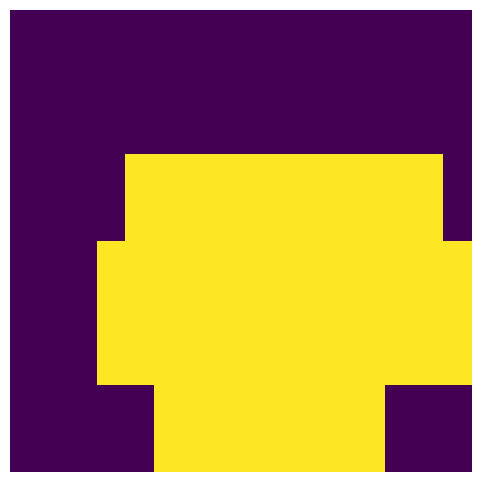

torch.Size([32, 32])


In [35]:
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

def plot_shape(shape_matrix):
    """Plot the generated shape."""
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,6))
    ax.set_facecolor('#301934')
    ax.imshow(shape_matrix, origin='upper')
    plt.axis('off')
    plt.show()

def load_item(item, action=''):
    if action=='':
        print(f'Eigenmodes: {item[0]}')
        print(f'Weights: {item[1]}')
        print(f'Params: {item[2]}')
        plot_shape(item[3])
    if action == 'shape':
        return item[3]
    
def quarter(matrix):
    return matrix[:32, :32]

class WaveguideDataset(Dataset):
    def __init__(self, h5_file):
        self.h5_file = h5py.File(h5_file, 'r')
        weights = self.h5_file['weight_train'][:]  # Shape: (N, 4)
        weight_sums = np.sum(weights, axis=1)  # Shape: (N,)
        patterns = self.h5_file['pattern_train'][:] # Shape: (N, 64, 64)
        mask = weight_sums < 100 # Mask that sorts for just good data 

        self.eigenmodes = self.h5_file['neff_train'][:]  # Shape: (N, 4)
        self.weights = weights[mask]  # Shape: (N, 4)
        self.paramss = self.h5_file['params_train'][:][mask]
        self.waveguides = np.array([quarter(p) for p in patterns])[mask]

    def __len__(self):
        return len(self.waveguides)

    def __getitem__(self, idx):
        eigenmode = self.eigenmodes[idx]  # (10, H, W)
        weight = self.weights[idx]  # (10,)
        params = self.paramss[idx]
        waveguide = self.waveguides[idx]  # (H, W)
        
        
        # Normalize (optional)
        eigenmode = torch.tensor(eigenmode, dtype=torch.float32)
        weight = torch.tensor(weight, dtype=torch.float32)
        params = torch.tensor(params, dtype=torch.float32)
        waveguide = torch.tensor(waveguide, dtype=torch.float32)

        return eigenmode, weight, params, waveguide

dataset = WaveguideDataset('train_test_split.h5')
load_item(dataset.__getitem__(2))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
print(dataset.__getitem__(2)[3].shape)

In [33]:
import torch
import matplotlib.pyplot as plt
param_names = ['Wavelength', 'Lattice', 'n_atom', 'n_substrate']

def plot_parameter_histograms(tensor, bins=100, titles=None):
    """
    Plots 4 histograms for a tensor of shape (N, 4),
    one for each parameter (column).
    
    Parameters:
    - tensor: torch.Tensor of shape (N, 4)
    - bins: number of histogram bins (default=50)
    - titles: list of titles for each subplot (optional)
    """
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    for i in range(4):
            row = i // 2
            col = i % 2
            axs[row, col].hist(tensor[:, i], bins=bins, edgecolor='black')
            axs[row, col].set_xlabel(f'Parameter {i}' if not titles else titles[i])
            axs[row, col].set_ylabel('Count')
            axs[row, col].set_title(f'Histogram of Parameter "{param_names[i]}"' if not titles else titles[i])
            axs[row, col].grid(True)

    plt.tight_layout()
    plt.show()

# plot_parameter_histograms(dataset.paramss)
mask = np.array([False,False,True,True])
x = dataset.paramss[:, mask][:]
# print(np.unique(x, axis=0))
print(len(np.unique(x, axis=0)))
print(len(x))


def count_unique_matrices(arr):
    """
    Counts how many unique 16x16 matrices are in a NumPy array of shape (N, 16, 16).

    Parameters:
    - arr: np.ndarray of shape (N, 16, 16)

    Returns:
    - int: number of unique matrices
    """
    N = arr.shape[0]
    flat = arr.reshape(N, -1)  # reshape each 16x16 matrix to 1D vector of length 256
    unique = np.unique(flat, axis=0)
    return unique.shape[0]

# y = dataset.waveguides
# num_matrix = count_unique_matrices(y)
# print(num_matrix)


296623
1098910


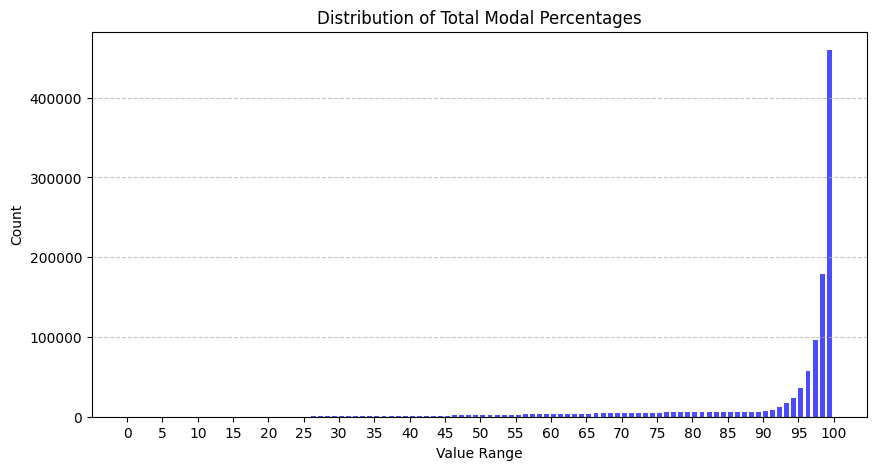

In [6]:
mode_percentage_dict = {}
def plot_bar_graph(data, title):
    """
    Plots a bar graph with bins from 0 to 100, incrementing by 1.
    Each bar represents the count of numbers in the list that fall within that range.
    
    Parameters:
        data (list of float): A list of float numbers between 0 and 100.
    """
    bins = np.arange(0, 101, 1)  # Define bins from 0 to 100 with step size 1
    hist, edges = np.histogram(data, bins=bins)  # Compute histogram
    
    plt.figure(figsize=(10, 5))
    plt.bar(edges[:-1], hist, width=.7, align='edge', color='b', alpha=0.7)
    plt.xlabel('Value Range')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(np.arange(0, 101, 5))  # Set x-axis ticks every 5 units
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    # for i in range(99, 0, -1):
    #     print(f'{i}% and Higher: {round(hist[i]/sum(hist)*100,2)}% of Trials')

plot_bar_graph(all_percentages, 'Distribution of Total Modal Percentages')

## use all, model has to kow which waveguides have more modes or not

Number of Items withe total Modal Percentage > 100: 15088
Number of Items with total Modal Percentage < 100 (valid): 1098910
Percent invalid training Items: 1.3729968787252824 %


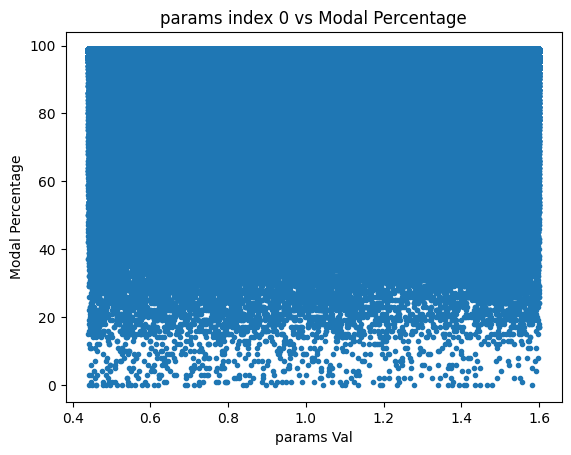

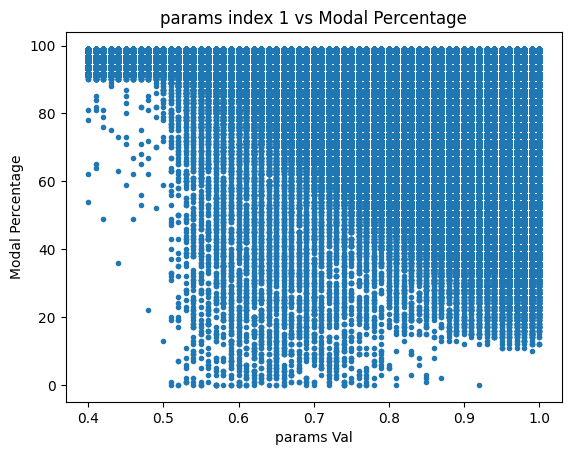

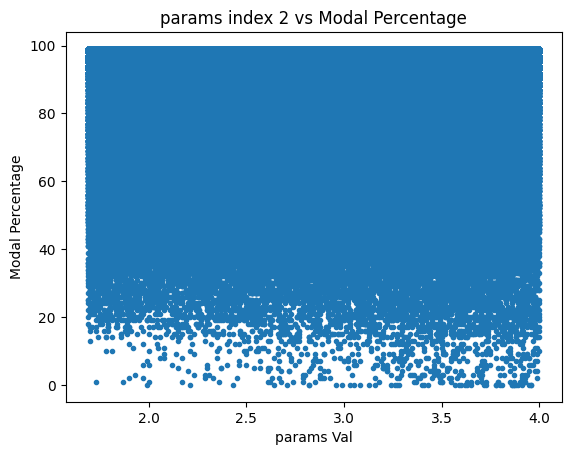

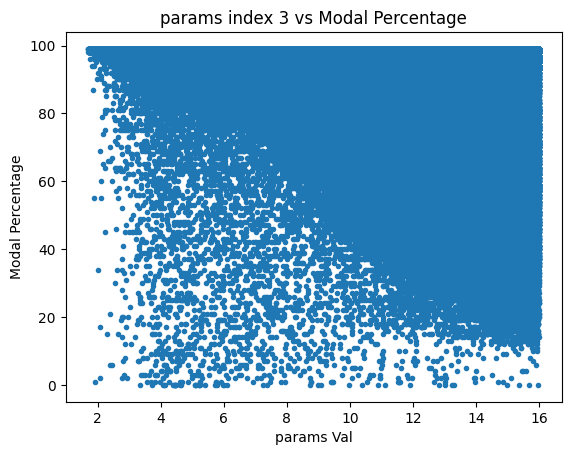

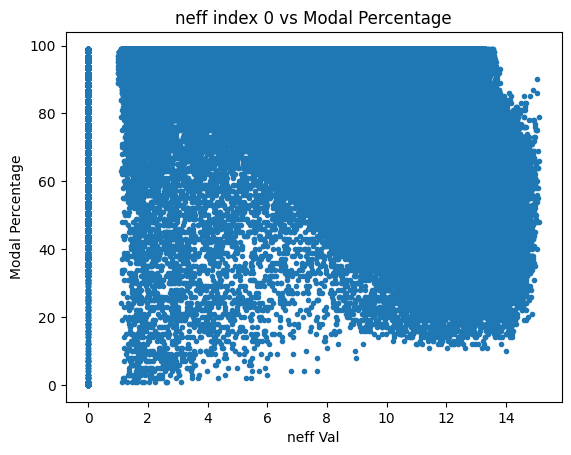

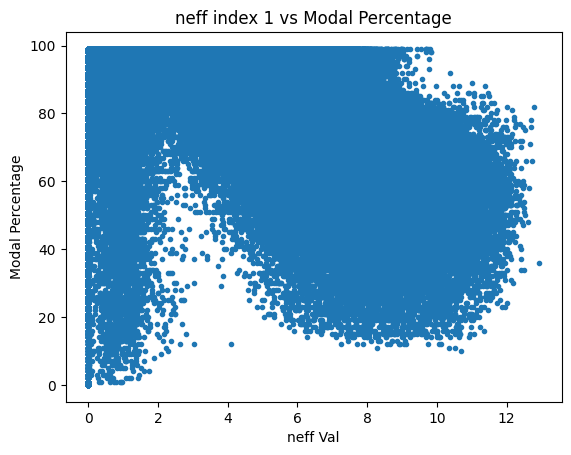

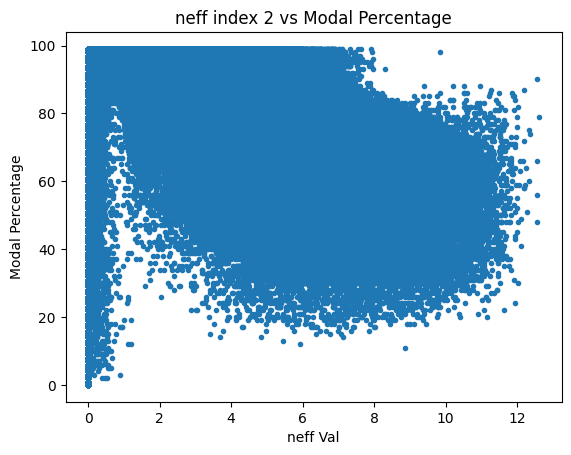

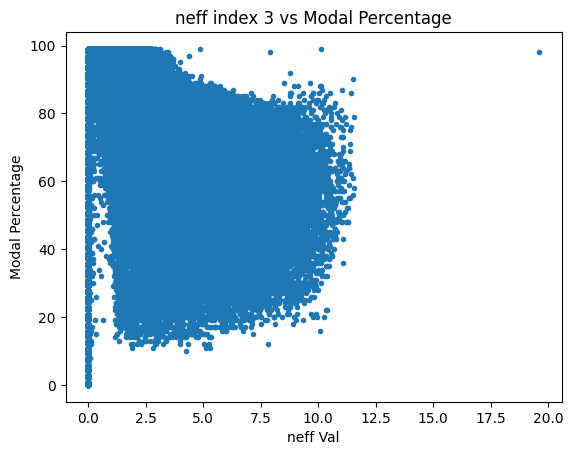

In [7]:
def get_item(item, key=''):
    if key=='':
        print(f'Neff: {item["neff"]}')
        print(f'Weights: {item["weights"]}')
        print(f'Params: {item["params"]}')
        plot_shape(item["pattern"])
    else:
        return item[key]

all_wrong = 0
all_right = 0
for key in sorted(p_labeled.keys()):
    if key > 99:
        # print(f'{key}: {len(p_labeled[key])}')
        all_wrong += len(p_labeled[key])
    else:
        all_right += len(p_labeled[key])

print(f'Number of Items withe total Modal Percentage > 100: {all_wrong}')
print(f'Number of Items with total Modal Percentage < 100 (valid): {all_right}')
print(f'Percent invalid training Items: {all_wrong/all_right * 100} %')
for label in ['params', 'neff']:
    for j in range(0,4):
        x = []
        y = []
        for key in p_labeled.keys():
            if key< 100:
                for i in p_labeled[key]:
                    y.append(key)
                    x.append(get_item(i, label)[j])
        plt.title(f'{label} index {j} vs Modal Percentage')
        plt.xlabel(f'{label} Val')
        plt.ylabel('Modal Percentage')
        # xy = np.vstack([x,y])
        # z = scipy.stats.gaussian_kde(xy)(xy)
        # idx = z.argsort()
        # x, y, z = x[idx], y[idx], z[idx]
        # plt.scatter(x, y, c=z, s=50, edgecolor=['none'])
        plt.errorbar(x,y, fmt='.')
        plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def plot_shape(shape_matrix):
    """Plot the generated shape."""
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,6))
    ax.set_facecolor('#301934')
    ax.imshow(shape_matrix, origin='upper')
    plt.axis('off')
    plt.show()
# Example usage
matrix = np.array([
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [1, 0, 1, 0],
    [0, 1, 0, 1]
])

# # plot_shape(matrix)
# keys = [i for i in range(0,100)]
# h = {key: [] for key in keys}

# x = np.random.normal(size=1000)
# y = x * 3 + np.random.normal(size=1000)

# # Calculate the point density
# xy = np.vstack([x,y])
# z = scipy.stats.gaussian_kde(xy)(xy)

# # Sort the points by density, so that the densest points are plotted last
# idx = z.argsort()
# x, y, z = x[idx], y[idx], z[idx]


# fig, ax = plt.subplots()
# ax.scatter(x, y, c=z, s=50, edgecolor=['none'])
# plt.show()